## Исследование данных о российском кинопрокате

Заказчик этого исследования — Министерство культуры Российской Федерации.  
Нужно изучить рынок российского кинопроката и выявить текущие тренды. Уделим внимание фильмам, которые получили государственную поддержку. Попробуем ответить на вопрос, насколько такие фильмы интересны зрителю.
Будем работать с данными, опубликованными на портале открытых данных Министерства культуры. Набор данных содержит информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск.

###  Откроем файлы с данными и объединим их в один датафрейм. 

Объединим данные таким образом, чтобы все объекты из датасета `mkrf_movies` обязательно вошли в получившийся датафрейм. 

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

In [2]:
# загрузим фалы с данными и ознакомимся с ними

try:
    df_movies = pd.read_csv('/datasets/mkrf_movies.csv')
    df_shows = pd.read_csv('/datasets/mkrf_shows.csv')
except:
    df_movies = pd.read_csv('/Users/alex/Desktop/Яндекс_Практикум/Проекты/Сборный_проект/mkrf_movies.csv')
    df_shows = pd.read_csv('/Users/alex/Desktop/Яндекс_Практикум/Проекты/Сборный_проект/mkrf_shows.csv')
    
df_movies.info()
df_shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

In [3]:
# объединим обе таблицы в одну по столбцу 'puNumber',
# предварительно приведя его к строковому типу
df_shows['puNumber'] = df_shows['puNumber'].astype(str)
df = df_movies.merge(df_shows, on='puNumber', how='left')

display(df.sample(1))
df.info()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3896,Амелия,221082810,2010-07-15T12:00:00.000Z,Художественный,"А Е Электра Продакшнз, Авалон Пикчерз, Фокс Се...",США - Канада,Мира Наир,"Рональд Басс, Дон Кармоди, Лидия Дин Пилчер",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,6.5,"драма,мелодрама,приключения",NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
 15  box_

Все строки столбца `box_office` вошли в новый датасет, данные не утеряны.  
Тип данных в столбце с номерами прокатных удостоверений делаем строковыми, т.к. это идентификаторы, работать как с числами с этим столбом не потребуется.

Таблица `mkrf_movies` содержит информацию из реестра прокатных удостоверений. У одного фильма может быть несколько прокатных удостоверений.
* title — название фильма;
* puNumber — номер прокатного удостоверения;
* show_start_date — дата премьеры фильма;
* type — тип фильма;
* film_studio — студия-производитель;
* production_country — страна-производитель;
* director — режиссёр;
* producer — продюсер;
* age_restriction — возрастная категория;
* refundable_support — объём возвратных средств государственной поддержки;
* nonrefundable_support — объём невозвратных средств государственной поддержки;
* financing_source — источник государственного финансирования;
* budget — общий бюджет фильма;
* ratings — рейтинг фильма на КиноПоиске;
* genres — жанр фильма.  
Столбец `budget` уже включает в себя полный объём государственной поддержки. Данные в этом столбце указаны только для тех фильмов, которые получили государственную поддержку.  

Таблица `mkrf_shows` содержит сведения о показах фильмов в российских кинотеатрах.
* puNumber — номер прокатного удостоверения;
* box_office — сборы в рублях.  

В таблице шестнадцать столбцов. Тип данных — float64, object.

In [4]:
# переименуем столбец
df.rename(columns = {'puNumber' : 'pu_number'}, inplace = True)
df.columns

Index(['title', 'pu_number', 'show_start_date', 'type', 'film_studio',
       'production_country', 'director', 'producer', 'age_restriction',
       'refundable_support', 'nonrefundable_support', 'budget',
       'financing_source', 'ratings', 'genres', 'box_office'],
      dtype='object')

### Предобработка данных

#### Типы данных, пропуски в датафрейме

- Проверим типы данных в датафрейме и преобразуем их там, где это необходимо.
- Объясним, почему заполнили пропуски определённым образом или почему не стали этого делать.

In [5]:
# столбец с датой конвертируем в формат даты
df['show_start_date'] = pd.to_datetime(df['show_start_date'], format = '%Y-%m-%d')
df['show_start_date'] = df['show_start_date'].dt.strftime('%Y-%m-%d')
df['show_start_date'] = pd.to_datetime(df['show_start_date'], format = '%Y-%m-%d')
df['show_start_date'].sample(1)

3083   2015-12-25
Name: show_start_date, dtype: datetime64[ns]

In [6]:
# столбец с рейтингом приведём к типу `float`
# заменим все значения типа `xx%` на `x.x`
rat = df['ratings'].str.replace('%', '', regex=True).astype(float)
df['ratings'] = rat.where(rat < 9.9, rat/10)
df['ratings'].unique()

array([7.2, 6.6, 6.8, 7.7, 8.3, 8. , 7.8, 8.1, 7.1, 6. , 7.4, 5.8, 8.7,
       6.3, 6.9, 5. , 4.3, 7.3, 7. , 6.4, nan, 8.2, 7.5, 6.7, 7.9, 5.9,
       6.2, 5.6, 6.5, 2.4, 7.6, 6.1, 8.6, 8.5, 8.8, 5.5, 5.1, 5.7, 5.4,
       9.9, 4.4, 4.5, 5.3, 4.1, 8.4, 2.6, 3.8, 4.6, 4.8, 4. , 3. , 1.6,
       4.2, 5.2, 4.7, 4.9, 3.9, 2.7, 3.3, 2.9, 2.8, 3.7, 1.4, 3.1, 9.7,
       3.5, 3.2, 1.5, 2.1, 2.5, 9.2, 3.4, 1.1, 3.6, 9.1, 9.4, 9. , 1.9,
       1. , 8.9, 1.3, 1.8, 1.2, 1.7, 9.8])

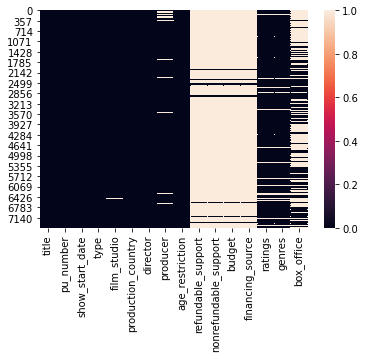

title - 0.0%
pu_number - 0.0%
show_start_date - 0.0%
type - 0.0%
film_studio - 0.24%
production_country - 0.03%
director - 0.12%
producer - 7.59%
age_restriction - 0.0%
refundable_support - 95.57%
nonrefundable_support - 95.57%
budget - 95.57%
financing_source - 95.57%
ratings - 12.92%
genres - 13.04%
box_office - 57.81%


In [7]:
# тепловая карта пропущенных значений
# пропущенные значения в процентах
sns.heatmap(df.isnull())
plt.show()

for cl in df.columns:
    pctm = np.mean(df[cl].isnull())
    print('{} - {}%'.format(cl, round((pctm*100), 2)))

In [10]:
# заменим нулевые значения в столбце с бюджетом фильма на пропущенные значения
df.loc[df['budget'] == 0, 'budget'] = np.nan
df['budget'].value_counts()

38000000.0     6
50000000.0     4
80000000.0     4
40000000.0     3
37142857.0     3
              ..
56693559.0     1
57166797.0     1
109814241.0    1
41000000.0     1
42252509.0     1
Name: budget, Length: 289, dtype: int64

Бюджет фильма не может быть нулевым (ну или это какие-то экстремальные значения).

In [11]:
# заменим нулевые значения в столбце со собрами фильма на пропущенные значения
df.loc[df['box_office'] == 0, 'box_office'] = np.nan
df['box_office'].value_counts()

200.0          13
300.0          12
360.0           9
500.0           8
400.0           8
               ..
809638458.6     1
220728.0        1
11332412.0      1
268550254.0     1
52984377.0      1
Name: box_office, Length: 2937, dtype: int64

Сборы у фильма, вышедшего в прокат, не могут быть нулевыми, это либо неверно заполненные, либо просто не указанные или аномальные значения.

**Вывод**  
Дату привели к специальному формату `datetime` .  
Столбец с рейтингом фильма привели к типу `float`, исправив некорректно записанные значения.  
В столбцах `refundable_support`, `budget`, `box_office`, -  нули заменили на пропуски.  
Пропущенные значения в столбцах `film_studio`, `production_country`, `director`, `producer`, `genres` имеют строковый тип данных, достаточно небольшйо процент пропусков и лучше оставить пропущенные значения, чем удалять, либо чем-то заполнять их.  
Пропущенные значения в столбцах `refundable_support`, `nonrefundable_support`, `budget` - связаны между собой, данные заполнены менее чем в `5%` случаев, если заполнять пропуски медианой, средним, etc., - можно кардинальным образом изменить дальнейшие выводы и подсчёты, поэтому пропуски оставим как есть.  
То же самое касается и столбца `box_office`, где указаны сборы фильмов, пропусков более `42%`, любые замены на медиану и т.п. изменят общую картину. Обрезать же базу данных по непропущенным значениям так же не лучший способ, можно сделать неверные выводы по неполным данным.

#### Дубликаты в датафрейме, категориальные значения

- Проверим, есть ли в данных дубликаты. Опишем причины, которые могли повлиять на появление дублей.
- Посмотрим, какая общая проблема встречается почти во всех категориальных столбцах;
- Исправим проблемные значения в поле `type`.

In [12]:
# подсчёт явных дубликатов
df.duplicated().sum()

0

Явных дубликатов нет.

In [13]:
# проверим дубликаты в столбце с номерами прокатных удостоверений
df['pu_number'].value_counts()

221054410    2
221154310    2
121016711    1
126001116    1
121013411    1
            ..
121004813    1
121024316    1
221027016    1
121020811    1
121001118    1
Name: pu_number, Length: 7484, dtype: int64

In [14]:
# посмотрим что за дублирущие номера прокатных удостоверений
display(df[(df['pu_number'] == '221054410')])
df[(df['pu_number'] == '221154310')]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
5067,Анализируй это!,221054410,2010-05-25,Художественный,"Уорнер Бразерс, Вилладж Роудшоу Филмз ЛТД",США-Австралия,ХЭрольд Рэмис,"Джейн Розенталь, Пола Уейнстейн",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.4,"комедия,криминал",NaN
5068,Анализируй то!,221054410,2010-05-25,Художественный,"Уорнер Бразерс, Виллидж Роадшоу Пикчерз, Эн-Пи...",США,Гарольд Реймис,"Джейн Розенталь, Паул Уэйнстейн",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,6.8,"комедия,криминал",NaN


,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
4638,Как жениться и остаться холостым,221154310,2010-12-17,Художественный,"Ше Вам, Скрипт Ассосье, Тэ Фэ 1 Фильм Продюксь...",Франция,Эрик Лартиго,"Амандин Било, Алан Шаба",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.0,"мелодрама,комедия",NaN
4639,Иоанна - женщина на папском престоле /По роман...,221154310,2010-12-17,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне ...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.6,"драма,мелодрама,история",NaN


Фильмы под прокатным удостоверением `221054410` вероятнее всего одинаковые, но не совсем ясно, как быть с различающейся информацией в других яйчейках.  
Фильмы под прокатным удостоверением `221154310` разные. Примем решение оставить эти данные, не удалять строки с данными.

In [15]:
# одинаковые названия фильмов
df['title'].value_counts()

День святого Валентина_                                        5
Гарри Поттер и Дары Смерти - Часть 1/По роману Дж.К.Ролинг/    4
Белая мгла /По комиксу Грега Рукка и Стива Либера/             4
Дорога /По новелле Кормака МкКарфи/                            4
Двойной копец                                                  4
                                                              ..
Цирк .                                                         1
Побочный эффект (2016)                                         1
Принцесса-лягушка: Тайна волшебной комнаты                     1
Осень                                                          1
Анимационный фильм "Сказки полуночи"                           1
Name: title, Length: 6772, dtype: int64

Фильмы вполне себе могут быть с одинаковыми названиями, это не уникальный идентификатор, но есть проблемы в написании названий фильмов, посторонние знаки: подчёркивания, точки, строчные и прописные буквы, запись иностранных названий в кириллице и т.п., - нет унифицированной формы записи названия фильма.

In [16]:
# удалим пробелы в начале значений, в столбце `type` 
df['type'] = df['type'].str.strip()
df['type'].unique()

array(['Художественный', 'Анимационный', 'Прочие', 'Документальный',
       'Научно-популярный', 'Музыкально-развлекательный'], dtype=object)

In [17]:
# количество фильмов у студий
df['film_studio'].value_counts()

Киностудия "Мосфильм"                                                                                         341
ООО "Мульт в кино"                                                                                             57
Анимаккорд Лтд                                                                                                 23
ООО "Мульт в кино"                                                                                             18
ФГУП "ТПО "Киностудия "Союзмультфильм"                                                                         16
                                                                                                             ... 
Филм Колони, Мо Фильм, Икс Игрек Зед Филмз                                                                      1
Мэзон до Синема, Судэн Компани, Нат/Болт Продакшнз, Тэ Пэ Эс Стар, Канал +, Мангуст Продюксьон, Кофинова 7      1
Раи Синема, Фанданго, Интеза Сан Паоло, Фарос Филм                                      

In [18]:
# страны, выпустившие фильмы
df['production_country'].value_counts()

США                                                               2172
Россия                                                            1821
СССР                                                               347
Франция                                                            301
Великобритания                                                     257
                                                                  ... 
Великобритания - Россия - КНР                                        1
Испания-Аргентина                                                    1
Чехия - Испания - США                                                1
Франция - Бельгия - Великобритания - США - Нидерланды - Канада       1
Грузия - Франция - Люксембург                                        1
Name: production_country, Length: 950, dtype: int64

In [19]:
# количество фильмов у режиссёров
df['director'].value_counts()

О.Семёнова               47
Стивен Содерберг         17
Д.Червяцов               17
Ридли Скотт              16
Тиль Швайгер             14
                         ..
В.Иванов, С.Комаров       1
Джулия Тэймор             1
Томми О'Хэйвер            1
Жак Перрен, Жак Клюзо     1
Митци Пейроне             1
Name: director, Length: 4811, dtype: int64

In [20]:
# количество фильмов у продюсеров
df['producer'].value_counts()

П.Смирнов                                        67
Олег Кузовков, Дмитрий Ловейко, Марина Ратина    28
С.Сельянов                                       18
Д.Ловейко, О.Кузовков                            17
А.Тельнов                                        11
                                                 ..
С.Сельянов, С.Бодров-старший                      1
Р.Хамдамов, А.Кончаловский, Л.Обминяная           1
Ю.Грымов                                          1
Фэн Сяоган, Джон Чонг                             1
Хироми Вакабаяси, Кацуя Масумото                  1
Name: producer, Length: 5349, dtype: int64

In [21]:
# выведем данные по возрастным категориям фильма
df['age_restriction'].value_counts()

«16+» - для детей старше 16 лет           2851
«18+» - запрещено для детей               1605
«12+» - для детей старше 12 лет           1593
«0+» - для любой зрительской аудитории     811
«6+» - для детей старше 6 лет              626
Name: age_restriction, dtype: int64

В возрастных категориях данные заполнены хорошо.

In [22]:
# уникальные данные по жанрам фильмов
df['genres'].value_counts()

драма                         476
комедия                       352
мелодрама,комедия             222
драма,мелодрама,комедия       189
драма,мелодрама               183
                             ... 
фэнтези,драма,биография         1
семейный,детектив,детский       1
мелодрама,триллер,история       1
комедия,криминал,биография      1
фэнтези,комедия,драма           1
Name: genres, Length: 742, dtype: int64

In [23]:
# уникальные данные по источнику государственного финансирования
df['financing_source'].value_counts()

Министерство культуры               164
Фонд кино                           146
Министерство культуры, Фонд кино     22
Name: financing_source, dtype: int64

**Вывод**  

В столбцах с категориальными значениями данные заполнены грязно, нет унифицированной формы для заполнения: подчёркивания, точки, строчные и прописные буквы, запись иностранных названий в кириллице и т.п.. Многие категории требуют мультииндекса, т.к. количество стран, жанров, продюсеров, режиссёров, киностудий - может быть больше одного, ну либо по каждой стране должен быть свой столбец с булевыми значениями.  
Единственные качественные заполненные категориальные данные - возрастные категории фильма, предполагаю, что при заполнении нужно просто выбрать значение из выпадающего списка, что положительным образом влияет на качество собираемых данных.  
Исправили значения в столбце `type`, были пробелы в названиях.

#### Количественные значения

Количество значений в столбцах `refundable_support`, `nonrefundable_support`, `budget`, `financing_source` одинаково и равно `332`. Отсюда следует, что данные по бюджету фильма есть только у тех фильмов, которые спонсировались государством, по остальным фильмам бюджет не предоставлен, возможно, это связано с особенностью работы киноиндустрии, когда конечный бюджет фильма либо не делается публичным, либо не считается целиком вовсе, ну а для гос.финансирования необходимо предоставить конкретные сметы.

In [24]:
# посмотрим на фильмы, финансируемые государством
df_pivot_table_financing_source = df.pivot_table(index = 'financing_source',
               values=['refundable_support',
                       'nonrefundable_support',
                       'budget'], aggfunc=sum).reset_index()
df_pivot_table_financing_source['ratio'] = round(((df_pivot_table_financing_source['nonrefundable_support'] +
                                                  df_pivot_table_financing_source['refundable_support'])/
                                                 df_pivot_table_financing_source['budget']*100), 2)

df_pivot_table_financing_source

,financing_source,budget,nonrefundable_support,refundable_support,ratio
0,Министерство культуры,1.146920e+10,4.836661e+09,0.000000e+00,42.17
1,"Министерство культуры, Фонд кино",2.626310e+09,8.599314e+08,3.255000e+08,45.14
2,Фонд кино,2.814475e+10,1.056510e+10,3.613500e+09,50.38


Весь указанный бюджет фильмов, почти наполовину проспонсирован государством.

In [25]:
# посмотрим числовую информацию по датафрейму
df.describe()

,refundable_support,nonrefundable_support,budget,ratings,box_office
count,3.320000e+02,3.320000e+02,3.150000e+02,6519.000000,3.134000e+03
mean,1.186446e+07,4.898099e+07,1.340961e+08,6.488173,7.706437e+07
std,2.491656e+07,5.998012e+07,1.912260e+08,1.114638,2.411784e+08
min,0.000000e+00,0.000000e+00,1.446246e+07,1.000000,4.000000e+01
25%,0.000000e+00,2.500000e+07,4.615387e+07,5.900000,1.010288e+05
50%,0.000000e+00,3.000000e+07,7.337955e+07,6.600000,2.409099e+06
75%,1.500000e+07,4.037500e+07,1.500043e+08,7.200000,2.456979e+07
max,1.800000e+08,4.000000e+08,2.305074e+09,9.900000,3.073569e+09


,budget,nonrefundable_support,refundable_support
budget,1.000000,0.628934,0.667699
nonrefundable_support,0.628934,1.000000,0.359622
refundable_support,0.667699,0.359622,1.000000


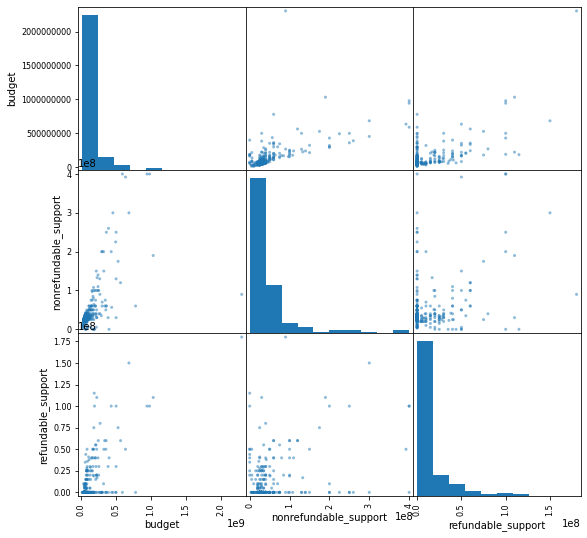

In [26]:
# построим матрицу диаграмм рассеяния
df_budget_pivot = df.pivot_table(index='pu_number',
                                 values=['budget', 'refundable_support', 'nonrefundable_support'], aggfunc='mean')
pd.plotting.scatter_matrix(df_budget_pivot, figsize=(9, 9))
df_budget_pivot.corr()

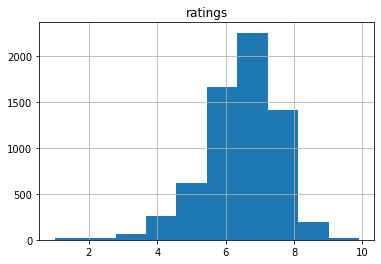

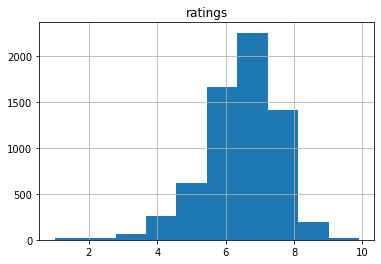

In [27]:
# посмотрим распределение данных в столбце с рейтингом фильмов
df.pivot_table(index='pu_number', values='ratings', aggfunc='median').hist()
df.pivot_table(index='pu_number', values='ratings', aggfunc='mean').hist()
plt.show()

Данные с рейтингом рапределены достаточно равномерно, графики среднего и медианы совпадают.

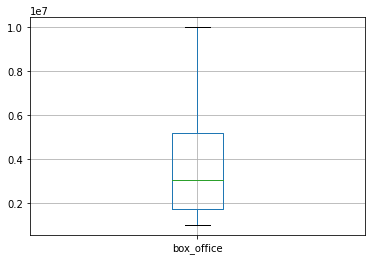

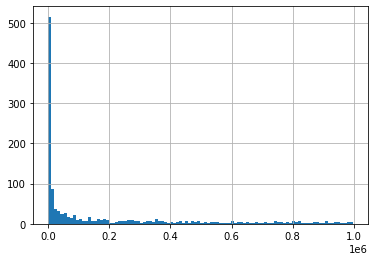

2409099.355

In [28]:
# посмотрим распределение данных в столбце с кассовым сбором фильмов
df.query('1000000<box_office<10000000').pivot_table(index='pu_number', values='box_office', aggfunc='mean').boxplot()
plt.show()
df.query('box_office<1000000')['box_office'].hist(bins=100)
plt.show()
display(df['box_office'].median())

Огромный разброс данных по столбцу со сборами фильмов.

In [29]:
df.query('box_office<100')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
151,Жестокий романс,111006013,2013-10-18,Художественный,"Киностудия ""Мосфильм""",СССР,Э.Рязанов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,8.1,"драма,мелодрама,история",40.0
1180,Астерикс и Обеликс в Британии 3D,121025012,2012-10-05,Художественный,"Уайлд Банч, Фиделите Фильм, Филм Кайрос, Синет...",Франция-Италия-Испания-Венгрия,Лоран Тирар,"Оливье Делбоск, Марк Миссонье",«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,5.6,"комедия,приключения,семейный",80.0
2274,Каменный цветок.,111016714,2014-12-01,Художественный,"Киностудия ""Мосфильм""",СССР,А.Птушко,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.1,"фэнтези,драма,мелодрама",50.0
3917,22 пули: Бессмертный,121006410,2010-04-01,Художественный,Еуроп Корпорейшн,Франция,Ришар Бери,"Люк Бессон, Дидье Хорау, Пьер-Анж Ле Погам",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.1,"боевик,драма,криминал",75.0


Есть целых четыре фильма со сборами менее 100 рублей!

In [30]:
# посмотрим количество фильмов со сбором менее миллиона
df.query('box_office<1000000')['box_office'].value_counts()

200.0       13
300.0       12
360.0        9
250.0        8
500.0        8
            ..
14430.0      1
268600.0     1
288019.5     1
132820.0     1
1570.0       1
Name: box_office, Length: 1037, dtype: int64

**Вывод**  

* Основная часть фильмов с бюджетом менее `25млн`.  
* Невозвратное госфинансирование фильмов, в основном, менее `5млн`.  
* Возвратное госфинансирование фильмов в основном менее `2.5млн`.  
* Максимальная сумма невозвратного финансирования: `400млн.`;
* Максимальная сумма возвратного финансирования: `180млн.`;
* Минимальная сумма невозвратного финансирования: `3млн.`;
* Минимальная сумма возвратного финансирования: `3.5млн.`;

Фонд кино спонсирует фильмы больше всего, причём основная масса предоставляемого финансирования - невозвратная.  
Весь указанный бюджет фильмов достаточно сильно скоррелирован с государственным финансированием.

* Основная часть фильмов имеет рейтинг в диапазоне `5.5-7.5`;
* Минимальный рейтинг фильмов: `1`;
* Максимальный рейтинг фильмов: `9.9`.
* Среднее значение суммы сборов фильма: `70млн`, а медиана: `2.4млн`, разница в несколько раз, что говорит о выборосах.
* Минимальная сумма сборов: `40`;
* Максимальная сумма сборов: `3млд`.  

Если миллиарды в сборах вполне могут быть и это реальные известные фильмы (Мстители, Холоп, Зверополис и т.п.), то большое количество минимальных значенияй, явно говорят нам о выбросах, некорректных данных (чаще всего это фильмы времён СССР, но год проката стоит вполне себе современный, например, фильм [Жестокий романс](https://www.kinopoisk.ru/film/45314/), что вызывает вопросы о корректности заполнения данных в целом). Можно было бы сделать срез до миллиона, но это почти треть всех данных по сборам. Поэтому оставим данные как есть.

#### Добавим новые столбцы

- Создадим столбец с информацией о годе проката. Выделим год из даты премьеры фильма.

In [31]:
# создадим столбец с годом проката фильма
df['year_show_start_date'] = df['show_start_date'].dt.year
df.sample(1)

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year_show_start_date
2334,Берлинале шортс: Чудо; Майк; Темная комната; Т...,121018514,2014-08-23,Художественный,"Электрик Балрум Продакшнс, Фильмалери 451, Кал...","Япония, Великобритания, Австрия, Германия, Ю.К...","Мираэ Мицуэ, Петрос Сильвестрос, Билли Ройз, Ф...","Лорен Дарк, Патрик Хоусен, Карим Дебба, Элке Г...",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.3,"драма,комедия,биография",NaN,2014


- Создадим два столбца: с именем и фамилией главного режиссёра и основным жанром фильма. В столбцы войдут первые значения из списка режиссёров и жанров соответственно.

In [32]:
# используем регулярные выражения для создания новых столбцов
# для имени и фамилии главного режиссёра возьмём все символы до первой запятой
# в жанре так же ограничимся всеми символами до запятой
# создадим два столбца

df['director_name'] = df['director'].str.extract(r'([^,]+)')
df['basic_genre'] = df['genres'].str.extract(r'([^,]+)')
df.sample(2)

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year_show_start_date,director_name,basic_genre
6374,Оцепеневшие от страха,121025018,2018-11-15,Художественный,"Мачако Фильмс, Институто Насьональ де Сине и А...",Аргентина,Демиан Рунья,"Раймундо Бассано, Фернандо Диас",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.1,ужасы,19481299.96,2018,Демиан Рунья,ужасы
1472,Джастин Бибер: Believe,126003716,2016-06-07,Прочие,"Дольфин Филмз, Бибер Тайм Филмз, Скутер Браун ...",США,Джон М.Чу,"Джастин Бибер, Скутер Браун, Стюарт Форд",«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,1.6,"концерт,музыка,документальный",NaN,2016,Джон М.Чу,концерт


- Посчитаем, какую долю от общего бюджета фильма составляет государственная поддержка.

In [33]:
# посчитаем долю государственной поддержки от общего бюджета фильма
budget_share = ((df['refundable_support'].sum() + df['nonrefundable_support'].sum())/df['budget'].sum()).mean()
print('Доля государственной поддержки от общего бюджета фильма:', '{:.2%} '.format(budget_share))

Доля государственной поддержки от общего бюджета фильма: 47.82% 


In [34]:
# создадим столбец с долей государственной поддержки
df['share_gov_support'] = (df['refundable_support'].sum() + df['nonrefundable_support'].sum())/df['budget'].sum()
df.sample(1)

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year_show_start_date,director_name,basic_genre,share_gov_support
2670,Достали!,111004015,2015-04-09,Художественный,"ООО ""Кинокомпания ""Ракурс""",Россия,А.Муратов,В.Сидоренко,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,NaN,NaN,1600.0,2015,А.Муратов,NaN,0.478233


### Исследовательский анализ данных


- Посмотрим, сколько фильмов выходило в прокат каждый год. Обратим внимание, что данные о прокате в кинотеатрах известны не для всех фильмов. Посчитаем, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах.

In [35]:
# посчитаем количество фильмов по годам
df.pivot_table(index = 'year_show_start_date', values=['box_office', 'pu_number'], aggfunc='count')

,box_office,pu_number
year_show_start_date,,
2010,101,985
2011,109,622
2012,123,593
2013,179,630
2014,273,807
2015,462,705
2016,525,818
2017,357,505
2018,475,891


Количество фильмов, выходящих в прокат и по которым есть данные, растёт с каждым годом, но есть большой разрыв между данными с проката фильмов и выданными прокатными лицензиями: фильмы либо не выходят в прокат, либо не раскрывают данные о сборах.

In [36]:
# посчитаем долю фильмов с данными о прокате
box_office_count = (df['box_office'].count() / df['pu_number'].count())
print('Доля фильмов с указанной информацией о прокате в кинотеатрах:', '{:.2%} '.format(box_office_count))

Доля фильмов с указанной информацией о прокате в кинотеатрах: 41.86% 


- Изучим, как менялась динамика проката по годам. В каком году сумма сборов была минимальной? А максимальной?

,box_office
year_show_start_date,
2010,2.428654e+06
2011,1.410276e+07
2012,6.955423e+06
2013,2.979971e+07
2014,7.444952e+09
2015,3.949737e+10
2016,4.786630e+10
2017,4.856371e+10
2018,4.966840e+10


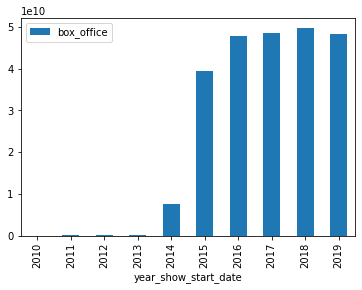

In [37]:
# динамика проката по годам
df_year_box = df.pivot_table(index = 'year_show_start_date', values='box_office', aggfunc='sum')
df_year_box.plot.bar()
df_year_box.describe()
df_year_box

Максимальная сумма сборов была в 2018 году (`4.9млрд`), минимальная - 2010 (`2.4млн`). С 2013 года наблюдается резкий рост, в 2016-2018 годах небольшой прирост, затем падение в 2019 году.

- С помощью сводной таблицы посчитаем среднюю и медианную сумму сборов для каждого года.

In [38]:
# посчитаем среднюю и медианную сумму сборов для каждого года
df.pivot_table(index = 'year_show_start_date', values='box_office', aggfunc=['median', 'mean'])

,median,mean
,box_office,box_office
year_show_start_date,,
2010,1710.000,2.404608e+04
2011,3000.000,1.293832e+05
2012,6220.000,5.654815e+04
2013,3580.000,1.664788e+05
2014,20400.000,2.727089e+07
2015,5003450.150,8.549213e+07
2016,3915041.020,9.117390e+07
2017,9968340.000,1.360328e+08


Медианные и средние значения достаточно сильно различаются, что может говорить о выбросах и аномальных значениях.

- Определим, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год? Фильмы с каким возрастным ограничением собрали больше всего денег в прокате? Меняется ли картина в зависимости от года? 

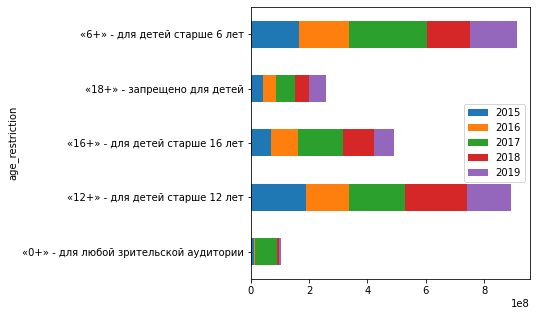

In [39]:
# построим график зависимости возрастного ограничения на сборы фильма,
# с ограничением в периоде проката от 2015 года 
df[(df['year_show_start_date'] >= 2015)].pivot_table(index = 'age_restriction',
                        values= 'box_office',
                        columns = 'year_show_start_date',  aggfunc='mean').plot.barh(stacked=True, figsize = (5,5))
plt.legend(loc=5)
plt.show()

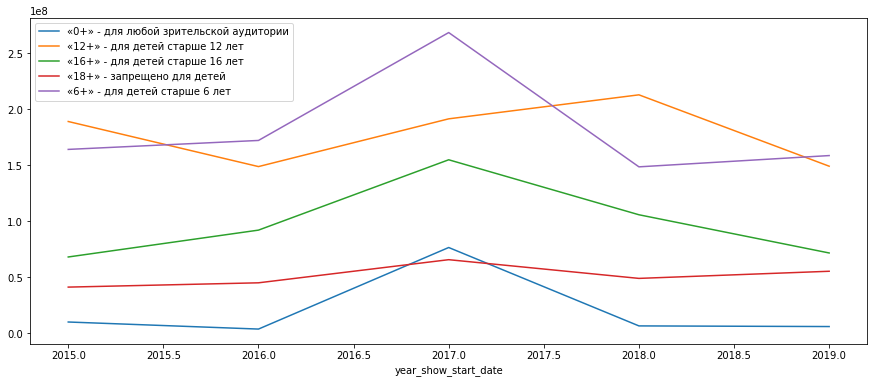

In [40]:
df[(df['year_show_start_date'] >= 2015)].pivot_table(index = 'year_show_start_date',
                        values= 'box_office',
                        columns = 'age_restriction',  aggfunc='mean').plot(figsize = (15,6))
plt.legend(loc=2)
plt.show()

Больше всего денег в прокате собирают категории  `6+` и `12+`, меньше всего категория `0+` .  
Но есть и различия по годам: в 2017 году, в категории `0+` были сборы больше, чем в категории `18+` .  
В разные годы выходят разные популярные многобюджетные фильмы с разным возрастным рейтингом, поэтому и есть разница по годам. 
Это может быть вызвано массовостью и наибольшим охватом различных групп людей, попадающих под эти категории.  
В категории  `0+`, несмотря на то, что она охватывает вообще всех людей, фильмы могут получаться слишком скучные и неинтересные для более возрастных групп.  
На фильмы категории `18+` не ходят не только люди младше 18 лет (чаще наоборот), но и не любящие связанные с этой категорией особенности фильмов (кровь, кишки, постельные сцены, ужасы и пр.).

### Шаг 4. Исследуем фильмы, которые получили государственную поддержку

In [41]:
# выделим в отдельный датафрейм данные с указанным бюджетом и гос.финансированием
government_support = df.dropna(subset=['nonrefundable_support'])
government_support.sample(3)
government_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332 entries, 1281 to 7478
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  332 non-null    object        
 1   pu_number              332 non-null    object        
 2   show_start_date        332 non-null    datetime64[ns]
 3   type                   332 non-null    object        
 4   film_studio            332 non-null    object        
 5   production_country     332 non-null    object        
 6   director               332 non-null    object        
 7   producer               330 non-null    object        
 8   age_restriction        332 non-null    object        
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 315 non-null    float64       
 12  financing_source       332 non-null    object        
 13  r

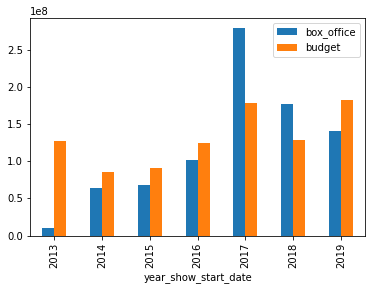

In [42]:
# посмотрим на окупаемость фильмов, сравнив среднее бюджета и сборов фильма
government_support.pivot_table(index = 'year_show_start_date',
                               values = ['budget', 'box_office'], aggfunc= 'mean').plot.bar()
plt.show()

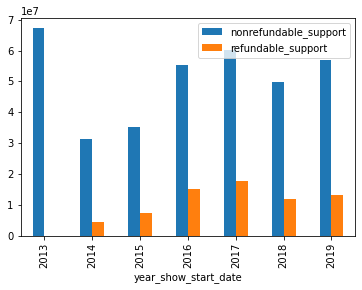

In [43]:
# сравнение возвратной и невозратной поддежки фильмов по годам
government_support.pivot_table(index = 'year_show_start_date',
                               values = ['refundable_support', 'nonrefundable_support'], aggfunc= 'mean').plot.bar()
plt.show()

Фильмы окупились всего в двух годах из наблюдаемых: 2017 (`41`) и 2018 (`56`).

In [44]:
# рейтинг спонсируемых фильмов
display(df.pivot_table(index = 'year_show_start_date',
                               values = 'ratings', aggfunc= 'median'))
government_support.pivot_table(index = 'year_show_start_date',
                               values = 'ratings', aggfunc= 'median')

,ratings
year_show_start_date,
2010,6.9
2011,6.7
2012,6.7
2013,6.6
2014,6.7
2015,6.4
2016,6.5
2017,6.4
2018,6.4


,ratings
year_show_start_date,
2013,6.7
2014,6.4
2015,6.2
2016,5.8
2017,6.2
2018,6.2
2019,6.2


Почти все спонсируемые фильмы ниже рейтингом (кроме 2013 года, но разница в `0.1` балл и всего два спонсируемых фильма), чем среднее или медианное значение по всей базе (в 2016 году разница максимальная, в `0.7` балла).

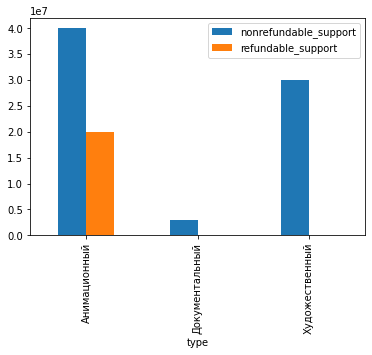

In [45]:
# на какие категории фильмов выделяет бюджет государство
government_support.pivot_table(index = 'type',
                               values = ['refundable_support', 'nonrefundable_support'], aggfunc= 'median').plot.bar()
plt.show()

Государство спонсирует анимационные, художественные и документальные фильмы.

### Шаг 5. Общий вывод

Предоставленные данные заполнены не лучшим образом, есть множество способов заполнять их лучше (самое очевидное - выпадающие списки и булевы значения в категориальных данных).  
Данные по предоставленному бюджету фильмов и их финансировании государством, представляют собой всего `4%` от общей базы данных, что катастрофически недостаточно для качественного анализа.  
Фонд кино является основным государственным спонсором, причём основная масса предоставляемого финансирования - невозвратная.  
Доля государственной поддержки от общего бюджета фильма, среднем составляет `47.82%` .  
Почти в половине случаев нет информации о сборах в кинотеатрах, фильмы либо не вышли в прокат, либо не раскрыли свои данные.
Максимальная сумма сборов была в 2018 году (`4.9млрд`), минимальная - 2010 (`2.4млн`).  
Больше всего денег в прокате собирают категории `6+` и `12+`, меньше всего категория `0+` .  
Финансируются фильмы документальные, анимационные и художественные.
Государственное финансирование чаще всего неудачно с точки зрения заработка: спонсируемые фильмы окупились только в 2017-2018 годах, во всём остальном периоде сборы были меньше бюджета. Поэтому и логичным выглядит рейтинг финансируемых гос.бюджетом фильмов, чаще всего он ниже среднего общего рейтинга, можно сделать вывод, что людям такие фильмы чаще всего менее интересны.
